In [1]:
import pandas as pd
from pandas import ExcelWriter

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings

In [4]:
warnings.filterwarnings('ignore')

**Januari 2019**

Detta är en datakörning till en trendartikel angående avhopp från kommunfullmäktige förra mandatperioden. Data är hämtat [från SCB](http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__ME__ME0107__ME0107A/ME0107T28/?rxid=d626ce81-71c7-40e8-9b7b-03158ada94f5). Resultatet publicerades i nr 4 2019 och finns att [läsa på webben](https://www.dagenssamhalle.se/nyhet/var-femte-hoppade-av-kommunfullmaktige-25971).

In [5]:
df = pd.read_csv('data/avhopp_totalt.csv',encoding='ISO-8859-1').dropna(axis=1)

In [6]:
valda = pd.read_csv('data/alla_valda.csv',encoding='ISO-8859-1')

In [7]:
valda['summa'] = valda.iloc[:,2:].sum(axis=1)

In [8]:
valda.head()

,region,valår,Moderaterna,Centerpartiet,Liberalerna,Kristdemokraterna,Miljöpartiet,Socialdemokraterna,Vänsterpartiet,Sverigedemokraterna,övriga partier,summa
0,0114 Upplands Väsby,2002,11,2,8,3,2,20,4,0,1,51
1,0114 Upplands Väsby,2006,17,2,6,3,3,16,3,1,0,51
2,0114 Upplands Väsby,2010,17,2,6,2,5,15,2,2,0,51
3,0114 Upplands Väsby,2014,13,2,4,2,5,16,4,3,2,51
4,0115 Vallentuna,2002,11,4,6,4,2,13,0,0,1,41


In [9]:
valda = valda[['region','valår','summa']]

In [10]:
valda['valår'] = valda['valår'].astype('str').apply(lambda x: x + f"-{int(x)+4}")

In [11]:
totalt = valda.pivot_table(index='region',columns='valår',values='summa').sum().reset_index().rename(columns={0:'summa'})

In [12]:
totalt['region'] = "00 Riket"

In [13]:
valda = pd.concat([totalt[valda.columns.tolist()],valda])

In [14]:
results = df.loc[(df['ålder']=='totalt 18+ år')&(df['kön']=='totalt')]

In [15]:
results = results.rename(columns={'årsintervall':'valår'})

In [16]:
res = results.merge(valda,on=['region','valår'],how='left').drop(['kön','ålder','status'],axis=1)

In [17]:
tot = res.loc[res['region']=='00 Riket']

In [18]:
writer = ExcelWriter('res/avhopp_resultat.xlsx')

In [19]:
tot

,region,valår,Valda i kommunfullmäktigval,summa
0,00 Riket,2002-2006,2162,13271
1,00 Riket,2006-2010,2185,13078
2,00 Riket,2010-2014,2516,12969
3,00 Riket,2014-2018,2830,12763


In [20]:
tot['andelar'] = ((tot['Valda i kommunfullmäktigval'] / tot['summa'])*100).round(1)

In [21]:
tot.rename(columns={'Valda i kommunfullmäktigval':'Avhopp i fullmäktige'}).to_excel(writer,sheet_name='totalt_riket',index=False)

In [22]:
res = res.loc[res['region']!='00 Riket']

In [23]:
res['andelar'] = ((res['Valda i kommunfullmäktigval'] / res['summa'])*100).round(1)

In [24]:
munis = res.loc[res['valår']=='2014-2018'].drop('valår',axis=1)

In [25]:
munis.region = munis.region.apply(lambda x: x[4:].strip())

In [26]:
munis.rename(columns={'Valda i kommunfullmäktigval':'Avhopp i fullmäktige'}).to_excel(writer,sheet_name='per_kommun_2014-2018',index=False)

In [27]:
test = res.drop('andelar',axis=1).groupby('region').sum().reset_index()

In [28]:
test['andelar'] = ((test['Valda i kommunfullmäktigval'] / test['summa'])*100).round(1)

In [29]:
test.region = test.region.apply(lambda x: x[4:].strip())

In [30]:
test.sort_values('andelar',ascending=False).rename(columns={'Valda i kommunfullmäktigval':'Avhopp i fullmäktige, 2002-2018',
                                                            'summa':'Antal stolar, 2002-2018',
                                                            'andelar':'Andelar avhopp, 2002-2018'}).to_excel(writer,sheet_name='totalt_02-18_per_kommun',index=False)

---

**Nu slutligen per parti:**

In [31]:
valda = pd.read_csv('data/alla_valda.csv',encoding='ISO-8859-1')

In [32]:
df = pd.read_csv('data/avhopp_partierna.csv',encoding='ISO-8859-1').dropna(axis=1)

In [33]:
res = df.loc[(df['region']=='00 Riket')&(df['kön']=='totalt')&(df['parti']!='totalt')]

In [34]:
res = res.drop(['region','kön','status'],axis=1).reset_index(drop=True)

In [35]:
valda = valda.melt(id_vars=['region','valår'],var_name='parti',value_name='valda')

In [36]:
valda['valår'] = valda['valår'].astype('str').apply(lambda x: x + f"-{int(x)+4}")

In [37]:
res = res.rename(columns={'årsintervall':'valår'})

In [38]:
res = res.merge(valda.groupby(['parti','valår']).sum().reset_index(),on=['parti','valår'],how='left')

In [39]:
res = res.rename(columns={'Valda i kommunfullmäktigval':'Avhopp i fullmäktige','valda':'Ledamöter totalt'})

In [40]:
res['Andel avhopp'] = ((res['Avhopp i fullmäktige'] / res['Ledamöter totalt'])*100).round(1)

In [41]:
res.pivot_table(index='parti',columns='valår',values='Andel avhopp').reset_index().to_excel(writer,sheet_name='per_parti',index=False)

In [42]:
writer.save()

In [43]:
res.head()

,parti,valår,Avhopp i fullmäktige,Ledamöter totalt,Andel avhopp
0,Moderaterna,2002-2006,336,2059,16.3
1,Moderaterna,2006-2010,473,2735,17.3
2,Moderaterna,2010-2014,552,2965,18.6
3,Moderaterna,2014-2018,559,2433,23.0
4,Centerpartiet,2002-2006,188,1689,11.1


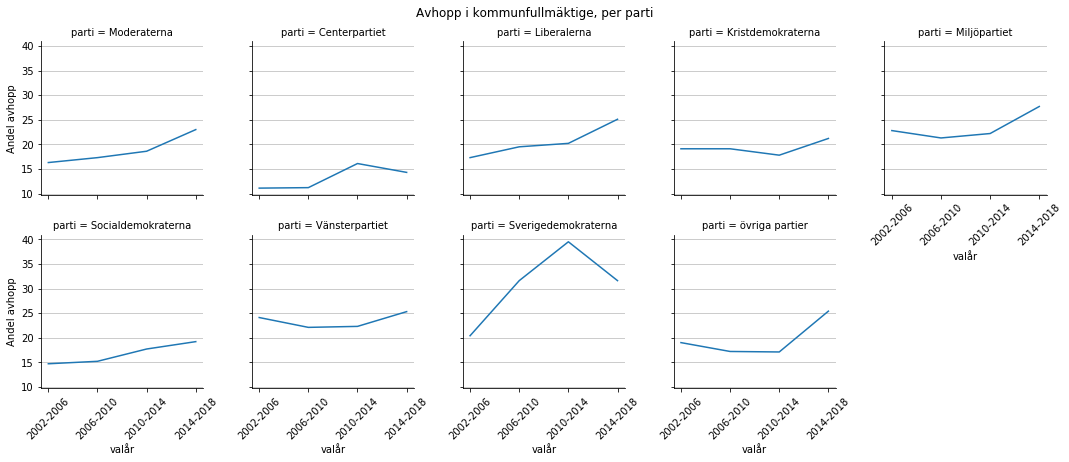

In [44]:
g = sns.FacetGrid(res,col='parti',col_wrap=5)
g.map(plt.plot,'valår','Andel avhopp')
g.set_xticklabels(rotation=45)

for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')
    
plt.subplots_adjust(top=0.90)
g.fig.suptitle('Avhopp i kommunfullmäktige, per parti ')

plt.savefig('res/avhopp_per_parti.png')

Johan önskade också avhopp efter parti och kommun:

In [50]:
res = df.loc[(df['region']!='00 Riket')&(df['kön']=='totalt')&(df['årsintervall']=='2014-2018'),['region','parti','Valda i kommunfullmäktigval']]

In [55]:
res = res.rename(columns={'Valda i kommunfullmäktigval':'Avhopp i fullmäktige'})\
    .pivot_table(index='region',columns='parti',values='Avhopp i fullmäktige').reset_index()

In [57]:
res.region = res.region.apply(lambda x: x[4:].strip())

In [60]:
res.to_excel(writer,sheet_name='kommun_efter_parti',index=False)

In [61]:
writer.save()